In [1]:
import json
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
class Scoreboard:
    def __init__(self, teams, challenges, solves):
        self.teams = teams
        self.challenges = challenges
        self.solves = solves
    def calculate_team_score_at_time(self, team_id, timestamp):
        solves_in_timerange = self.solves.before(timestamp)
        solved_challenge_ids = solves_in_timerange.for_team(team_id).df.challenge_id.values
        total_score = 0
        for cid in solved_challenge_ids:
            timebounded_challenge_solves = solves_in_timerange.for_challenge(cid)
            total_score += self.challenges[cid].point_value(timebounded_challenge_solves, team_id)
        return total_score
    def calculate_team_score_as_time_series(self, team_id):
        idx = self.solves.for_team(team_id).df.index
        return pd.Series([self.calculate_team_score_at_time(team_id, idx) for idx in idx], index=idx, name=self.teams[team_id].name)
    def __repr__(self):
        return f"[Scoreboard with {len(teams)} teams, {len(challenges)} challenges, and {len(solves.df.index)} solves]"
    
class Solves:
    def __init__(self, df):
        self.df = df
    def from_json(solves_r):
        solve_idx = pd.DatetimeIndex(map(lambda x: x['created_at'], solves_r))
        solve_cols = ['solve_id', 'team_id', 'challenge_id']
        solve_data = map(lambda x: [x['id'], x['team_id'], x['challenge_id']], solves_r)
        solves = pd.DataFrame(solve_data, index=solve_idx, columns=solve_cols)
        return Solves(solves)
    def for_team(self, team_id):
        return Solves(self.df[self.df['team_id']==team_id])
    def for_challenge(self, challenge_id):
        return Solves(self.df[self.df['challenge_id']==challenge_id])
    def before(self, max_time):
        return Solves(self.df[:max_time])
    def __repr__(self):
        return f"[Solves df={self.df}]"

class Challenge:
    def __init__(self, challenge_id, name, score_strategy):
        self.challenge_id = challenge_id
        self.name = name
        self.score_strategy = score_strategy
    def point_value(self, solves, team_id):
        return self.score_strategy.point_value(solves, team_id)
    def __repr__(self):
        return f"[Challenge challenge_id={self.challenge_id} name={self.name} score_strategy={self.score_strategy}]"
        
class Team:
    def __init__(self, team_id, name, solved_challenges=[]):
        self.team_id = team_id
        self.name = name
        self.solved_challenges = solved_challenges
    def from_json(team_json):
        return Team(team_json['id'], team_json['name'])
    def add_solve(self, time, challenge_id):
        self.solved_challenges.add(challenge_id)
    def __str__(self):
        return f"[team_id={self.team_id}, name={self.name}, solves={self.solved_challenges}]"
    def __repr__(self):
        return self.__str__()
    
def plot_for_strat(all_teams, all_solves, strat_json_loader):
    s_challenges = {x.challenge_id:x for x in map(strat_json_loader, challenges_r)}
    s_scoreboard = Scoreboard(all_teams, s_challenges, all_solves)
    s_series = map(s_scoreboard.calculate_team_score_as_time_series, team_ids)
    s_ts = pd.concat(s_series, axis=1)
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=s_ts, dashes=False)
    return s_ts.apply(lambda x: x[x.last_valid_index()])

In [3]:
class SimplePointValueStrategy:
    def __init__(self, start_points, breakthrough_point_values=[]):
        self.start_points = start_points
        self.breakthrough_point_values = breakthrough_point_values
    def point_value(self, solves, team_id=None):
        self._validate(solves)
        base_points = self.base_point_value(solves)
        point_offset = self.breakthrough_point_value(solves, team_id)
        return base_points + point_offset
    def _validate(self, solves):
        # Need to make sure all of the supplied solves are for the same challenge
        cids = solves.df.challenge_id.unique()
        if cids.size != 1:
            raise BaseException(f'Expected exactly one challenge_id in solve data, but got {cids}')
    def breakthrough_point_value(self, solves, team_id=None):
        if team_id == None or not self.breakthrough_point_values:
            return 0
        print(solves[:len(self.breakthrough_point_values)])
        breakthrough_solves = solves[:len(self.breakthrough_point_values)]
        solve_indices = breakthrough_solves.query(f'team_id == {team_id}').index
        #print('shape', solve_indices.shape)
        if solve_indices.shape[0] == 0:
            # No results returned
            return 0
        solve_index = solve_indices[0]
        solve_row_number = breakthrough_solves.index.get_loc(solve_index)
        return self.breakthrough_point_values[solve_row_number]

    # Overrideable methods below
    def base_point_value(self, solves):
        return self.start_points
    def __repr__(self):
        rep = f'[SimplePointValueStrategy start_points={self.start_points}'
        if self.breakthrough_point_values:
            return rep + f' breakthrough_points={self.breakthrough_point_values}'
        return rep + ']'

class SimplePointValueChallengeLoader:
    def from_json(challenge_json):
        strategy = SimplePointValueStrategy(challenge_json['points'])
        return Challenge(challenge_id=challenge_json['id'],
                        name=challenge_json['name'],
                        score_strategy=strategy)
        

In [4]:
# From CTFd
# https://github.com/CTFd/DynamicValueChallenge
class CtfdDecayPointValueStrategy(SimplePointValueStrategy):
    def __init__(self, max_points, min_points, decay, breakthrough_point_values=[]):
        self.max_points = max_points
        self.min_points = min_points
        self.decay = decay

        self.breakthrough_point_values = breakthrough_point_values

    def base_point_value(self, solves):
        a = self.max_points
        b = self.min_points
        s = self.decay
        solve_count = solves.df.shape[0]
        return math.ceil((((b-a)/(s**2)) * solve_count**2) + a)

    def __repr__(self):
        rep = f'[CtfdDecayPointValueStrategy min={self.min_points} max={self.max_points} decay={self.decay}'
        if self.breakthrough_point_values:
            return rep + f' breakthrough_points={self.breakthrough_point_values}'
        return rep + ']'


class CtfdDecayPointValueChallengeLoader:
    def from_json(challenge_json):
        strategy = CtfdDecayPointValueStrategy(500, 100, 1500)
        return Challenge(challenge_id=challenge_json['id'],
                        name=challenge_json['name'],
                        score_strategy=strategy)

In [5]:
# From 35C3 CTF
class EsprDecayPointValueStrategy(SimplePointValueStrategy):
    def __init__(self, max_points, min_points, breakthrough_point_values=[]):
        self.max_points = max_points
        self.min_points = min_points

        self.breakthrough_point_values = breakthrough_point_values

    def base_point_value(self, solve_data):
        max_points = self.max_points
        min_points = self.min_points
        solves = solve_data.df.shape[0]
        return int(round(min_points + (max_points - min_points) / (1 + (max(0, solves - 1) / 11.92201) ** 1.206069)))

    def __repr__(self):
        rep = f'[EsprDecayPointValueStrategy min={self.min_points} max={self.max_points}'
        if self.breakthrough_point_values:
            return rep + f' breakthrough_points={self.breakthrough_point_values}'
        return rep + ']'


class EsprDecayPointValueChallengeLoader:
    def from_json(challenge_json):
        strategy = EsprDecayPointValueStrategy(500, 30)
        return Challenge(challenge_id=challenge_json['id'],
                        name=challenge_json['name'],
                        score_strategy=strategy)

In [6]:
# Evenly divide points amongst solvers
class EvenDividePointValueStrategy(SimplePointValueStrategy):
    def __init__(self, max_points, breakthrough_point_values=[]):
        self.max_points = max_points
        self.breakthrough_point_values = breakthrough_point_values

    def base_point_value(self, solve_data):
        solves = solve_data.df.shape[0]
        return math.ceil(self.max_points / solves)

    def __repr__(self):
        rep = f'[EvenDividePointValueStrategy max={self.max_points}'
        if self.breakthrough_point_values:
            return rep + f' breakthrough_points={self.breakthrough_point_values}'
        return rep + ']'


class EvenDividePointValueChallengeLoader:
    def from_json(challenge_json):
        strategy = EvenDividePointValueStrategy(500)
        return Challenge(challenge_id=challenge_json['id'],
                        name=challenge_json['name'],
                        score_strategy=strategy)

In [7]:
challenges_r = json.load(open('./data/legitbs/2017-quals/challenges.json', 'r'))
solves_r = json.load(open('./data/legitbs/2017-quals/solutions.json', 'r'))
teams_r  = json.load(open('./data/legitbs/2017-quals/teams.json', 'rb'))

In [8]:
teams = {x.team_id:x for x in map(Team.from_json, teams_r)}
solves = Solves.from_json(solves_r)

In [9]:
#simple_challenges = {x.challenge_id:x for x in map(SimplePointValueChallengeLoader.from_json, challenges_r)}
#simple_scoreboard = Scoreboard(teams, simple_challenges, solves)

In [10]:
#ctfd_challenges = {x.challenge_id:x for x in map(CtfdDecayPointValueChallengeLoader.from_json, challenges_r)}
#ctfd_scoreboard = Scoreboard(teams, ctfd_challenges, solves)

In [11]:
# Manually-entered top 15 from https://legitbs.net/statdump_2017/scoreboard.html
top_15 = ['PPP', 'Tea Deliverers', 'Shellphish', 'DEFKOR', "A*0*E",
          'hacking4danbi', '!SpamAndHex', 'RRR', 'Team Rocket ☠️', 'Lab RATs',
          'koreanbadass', 'Samurai', 'Eat Sleep Pwn Repeat', '9447', 'TokyoWesterns with AST']
teams_by_name = {teams[t].name:t for t in teams}
team_ids = [teams_by_name[x] for x in top_15]

PPP                       62.0
Tea Deliverers            56.0
Shellphish                53.0
DEFKOR                    51.0
A*0*E                     54.0
hacking4danbi             54.0
!SpamAndHex               52.0
RRR                       50.0
Team Rocket ☠️            50.0
Lab RATs                  48.0
koreanbadass              46.0
Samurai                   47.0
Eat Sleep Pwn Repeat      47.0
9447                      47.0
TokyoWesterns with AST    49.0
dtype: float64

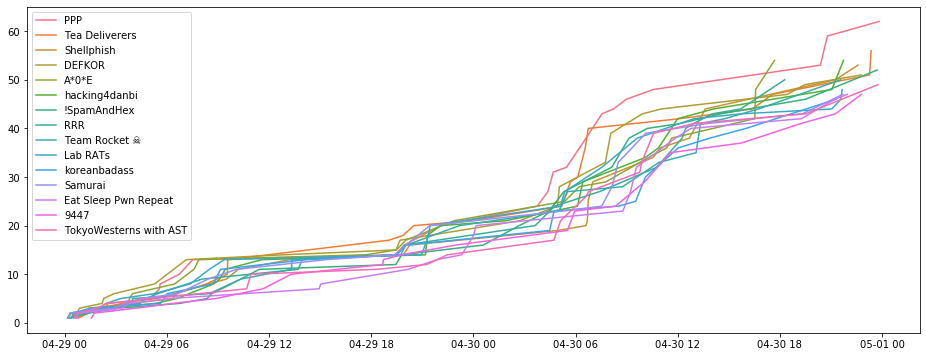

In [19]:
simple_scores = plot_for_strat(teams, solves, SimplePointValueChallengeLoader.from_json)
simple_scores

PPP                       11961.0
Tea Deliverers            11461.0
Shellphish                10962.0
DEFKOR                    10962.0
A*0*E                     10965.0
hacking4danbi             10962.0
!SpamAndHex               10461.0
RRR                       10464.0
Team Rocket ☠️            10462.0
Lab RATs                  10462.0
koreanbadass               9963.0
Samurai                    9962.0
Eat Sleep Pwn Repeat       9962.0
9447                       9962.0
TokyoWesterns with AST     9961.0
dtype: float64

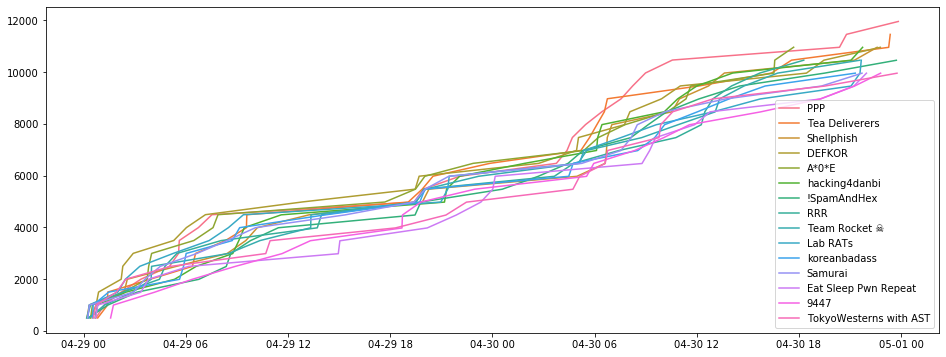

In [13]:
ctfd_scores = plot_for_strat(teams, solves, CtfdDecayPointValueChallengeLoader.from_json)
ctfd_scores

PPP                       3514.0
Tea Deliverers            3250.0
Shellphish                2823.0
DEFKOR                    2800.0
A*0*E                     3228.0
hacking4danbi             2770.0
!SpamAndHex               2501.0
RRR                       2746.0
Team Rocket ☠️            2477.0
Lab RATs                  2446.0
koreanbadass              2318.0
Samurai                   2137.0
Eat Sleep Pwn Repeat      2135.0
9447                      2093.0
TokyoWesterns with AST    2060.0
dtype: float64

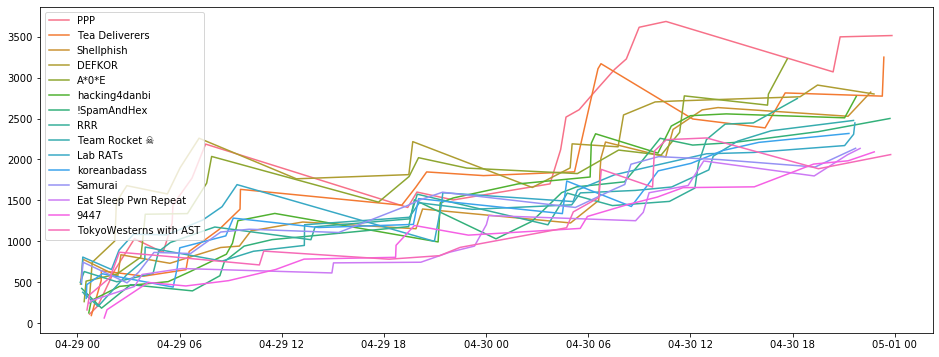

In [14]:
espr_scores = plot_for_strat(teams, solves, EsprDecayPointValueChallengeLoader.from_json)
espr_scores

PPP                       669.0
Tea Deliverers            647.0
Shellphish                412.0
DEFKOR                    404.0
A*0*E                     887.0
hacking4danbi             361.0
!SpamAndHex               359.0
RRR                       508.0
Team Rocket ☠️            315.0
Lab RATs                  302.0
koreanbadass              309.0
Samurai                   247.0
Eat Sleep Pwn Repeat      247.0
9447                      236.0
TokyoWesterns with AST    228.0
dtype: float64

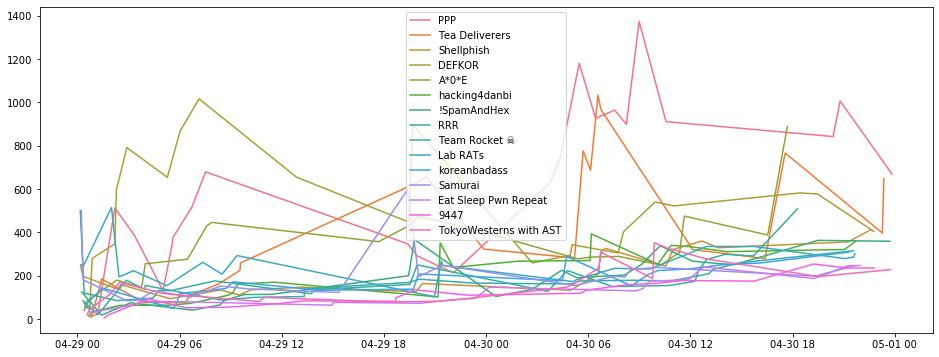

In [15]:
even_scores = plot_for_strat(teams, solves, EvenDividePointValueChallengeLoader.from_json)
even_scores

In [16]:
sorted_scores = map(lambda x: x.sort_values(ascending=False), [simple_scores, ctfd_scores, espr_scores, even_scores])

team_places = list(map(lambda x: pd.Series(range(1, 16), index=x.index), sorted_scores))
simple_team_places = team_places[0]

pd.concat(team_places, axis=1, keys=['simple', 'ctfd', '35c3', 'even_divide'], sort=False).sort_values(ascending=True, by='simple')

,simple,ctfd,35c3,even_divide
PPP,1,1,1,2
Tea Deliverers,2,2,2,3
hacking4danbi,3,4,6,7
A*0*E,4,3,3,1
Shellphish,5,6,4,5
!SpamAndHex,6,10,8,8
DEFKOR,7,5,5,6
Team Rocket ☠️,8,9,9,9
RRR,9,7,7,4
TokyoWesterns with AST,10,15,15,15


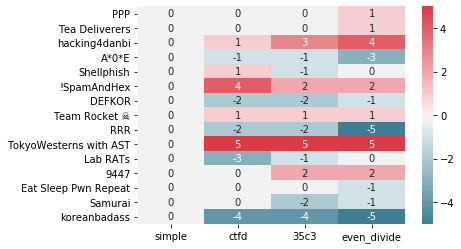

In [17]:
team_place_diffs = map(lambda x: x - simple_team_places, team_places)
place_diffs = pd.concat(team_place_diffs, sort=False, axis=1, keys=['simple', 'ctfd', '35c3', 'even_divide']).sort_values(ascending=True, by='simple')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(place_diffs, cmap=cmap, square=False, annot=True)

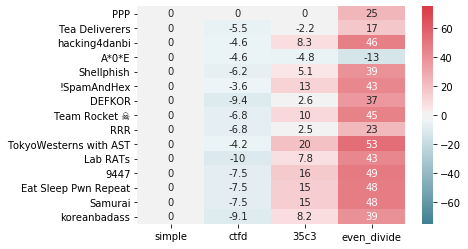

In [18]:
def normalize(scores):
    max_score = scores.max()
    return scores / max_score * 100
sorted_scores = map(lambda x: x.sort_values(ascending=False), [simple_scores, ctfd_scores, espr_scores, even_scores])
normalized_scores = list(map(normalize, sorted_scores))
simple_normalized_scores = normalized_scores[0]
normalized_score_diffs = [simple_normalized_scores - x for x in normalized_scores]

normalized_score_df = pd.concat(normalized_score_diffs, sort=False, axis=1, keys=['simple', 'ctfd', '35c3', 'even_divide']).sort_values(ascending=False, by='simple')
sns.heatmap(normalized_score_df, cmap=cmap, square=False, annot=True, center=0, vmin=-75, vmax=75)